<a href="https://colab.research.google.com/github/praveenraghuvanshi1512/EIP4/blob/master/Session5/Assignment5/EIP4_A5_Praveen_Raghuvanshi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# mount gdrive and unzip data
from google.colab import drive
drive.mount('/content/gdrive')
!unzip -q "/content/gdrive/My Drive/hvc_data.zip"
# look for `hvc_annotations.csv` file and `resized` dir
%ls 

In [0]:
%tensorflow_version 1.x

import cv2
import json

import numpy as np
import pandas as pd

from functools import partial
from pathlib import Path 
from tqdm import tqdm

from google.colab.patches import cv2_imshow

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder


from keras.applications import VGG16
from keras.layers.core import Dropout
from keras.layers.core import Flatten
from keras.layers.core import Dense
from keras.layers import Input
from keras.models import Model, load_model
from keras.optimizers import SGD
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, LearningRateScheduler

import keras.backend as K

import matplotlib.image as mpimg
import matplotlib.pyplot as plt 

In [0]:
# load annotations
df = pd.read_csv("hvc_annotations.csv")
del df["filename"] # remove unwanted column
df.head()

In [0]:
# Print random image
fig = plt.figure(figsize=(16, 16))
columns = 4
rows = 5
ax = []

for i in range(1, columns * rows + 1):
    
    x = mpimg.imread(df.image_path[i])
    ax.append(fig.add_subplot(rows, columns, i))
    ax[-1].set_title("Sex:"+str(df.gender[i])+",  Age:"+str(df.age[i]))
    plt.imshow(x)

plt.show()

imageIndex = 1
print("Attributes of image at index: " + str(imageIndex))
print(df.iloc[imageIndex])

In [0]:
# one hot encoding of labels

one_hot_df = pd.concat([
    df[["image_path"]],
    pd.get_dummies(df.gender, prefix="gender"),
    pd.get_dummies(df.imagequality, prefix="imagequality"),
    pd.get_dummies(df.age, prefix="age"),
    pd.get_dummies(df.weight, prefix="weight"),
    pd.get_dummies(df.carryingbag, prefix="carryingbag"),
    pd.get_dummies(df.footwear, prefix="footwear"),
    pd.get_dummies(df.emotion, prefix="emotion"),
    pd.get_dummies(df.bodypose, prefix="bodypose"),
], axis = 1)

one_hot_df.head().T

In [0]:
import keras
import numpy as np

# Label columns per attribute
_gender_cols_ = [col for col in one_hot_df.columns if col.startswith("gender")]
_imagequality_cols_ = [col for col in one_hot_df.columns if col.startswith("imagequality")]
_age_cols_ = [col for col in one_hot_df.columns if col.startswith("age")]
_weight_cols_ = [col for col in one_hot_df.columns if col.startswith("weight")]
_carryingbag_cols_ = [col for col in one_hot_df.columns if col.startswith("carryingbag")]
_footwear_cols_ = [col for col in one_hot_df.columns if col.startswith("footwear")]
_emotion_cols_ = [col for col in one_hot_df.columns if col.startswith("emotion")]
_bodypose_cols_ = [col for col in one_hot_df.columns if col.startswith("bodypose")]

class PersonDataGenerator(keras.utils.Sequence):
    """Ground truth data generator"""

    
    def __init__(self, df, batch_size=32, shuffle=True):
        self.df = df
        self.batch_size=batch_size
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(self.df.shape[0] / self.batch_size))

    def __getitem__(self, index):
        """fetch batched images and targets"""
        batch_slice = slice(index * self.batch_size, (index + 1) * self.batch_size)
        items = self.df.iloc[batch_slice]
        image = np.stack([cv2.imread(item["image_path"]) for _, item in items.iterrows()])
        target = {
            "gender_output": items[_gender_cols_].values,
            "image_quality_output": items[_imagequality_cols_].values,
            "age_output": items[_age_cols_].values,
            "weight_output": items[_weight_cols_].values,
            "bag_output": items[_carryingbag_cols_].values,
            "pose_output": items[_bodypose_cols_].values,
            "footwear_output": items[_footwear_cols_].values,
            "emotion_output": items[_emotion_cols_].values,
        }
        return image, target

    def on_epoch_end(self):
        """Updates indexes after each epoch"""
        if self.shuffle == True:
            self.df = self.df.sample(frac=1).reset_index(drop=True)


In [0]:
from sklearn.model_selection import train_test_split
train_df, val_df = train_test_split(one_hot_df, test_size=0.15)
train_df.shape, val_df.shape

In [0]:
train_df.head()

In [0]:
# create train and validation data generators
train_gen = PersonDataGenerator(train_df, batch_size=32)
valid_gen = PersonDataGenerator(val_df, batch_size=64, shuffle=False)

In [0]:
# get number of output units from data
images, targets = next(iter(train_gen))
num_units = { k.split("_output")[0]:v.shape[1] for k, v in targets.items()}
num_units

In [0]:
backbone = VGG16(
    weights=None, 
    include_top=False, 
    input_tensor=Input(shape=(224, 224, 3))
)

neck = backbone.output
neck = Flatten(name="flatten")(neck)
neck = Dense(512, activation="relu")(neck)


def build_tower(in_layer):
    neck = Dropout(0.2)(in_layer)
    neck = Dense(128, activation="relu")(neck)
    neck = Dropout(0.3)(neck)
    neck = Dense(128, activation="relu")(neck)
    return neck


def build_head(name, in_layer):
    return Dense(
        num_units[name], activation="softmax", name=f"{name}_output"
    )(in_layer)

# heads
gender = build_head("gender", build_tower(neck))
image_quality = build_head("image_quality", build_tower(neck))
age = build_head("age", build_tower(neck))
weight = build_head("weight", build_tower(neck))
bag = build_head("bag", build_tower(neck))
footwear = build_head("footwear", build_tower(neck))
emotion = build_head("emotion", build_tower(neck))
pose = build_head("pose", build_tower(neck))


model = Model(
    inputs=backbone.input, 
    outputs=[gender, image_quality, age, weight, bag, footwear, pose, emotion]
)

In [0]:
# freeze backbone
for layer in backbone.layers:
	layer.trainable = False

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 224, 224, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 224, 224, 64) 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 112, 112, 64) 0           block1_conv2[0][0]               
____________________________________________________________________________________________

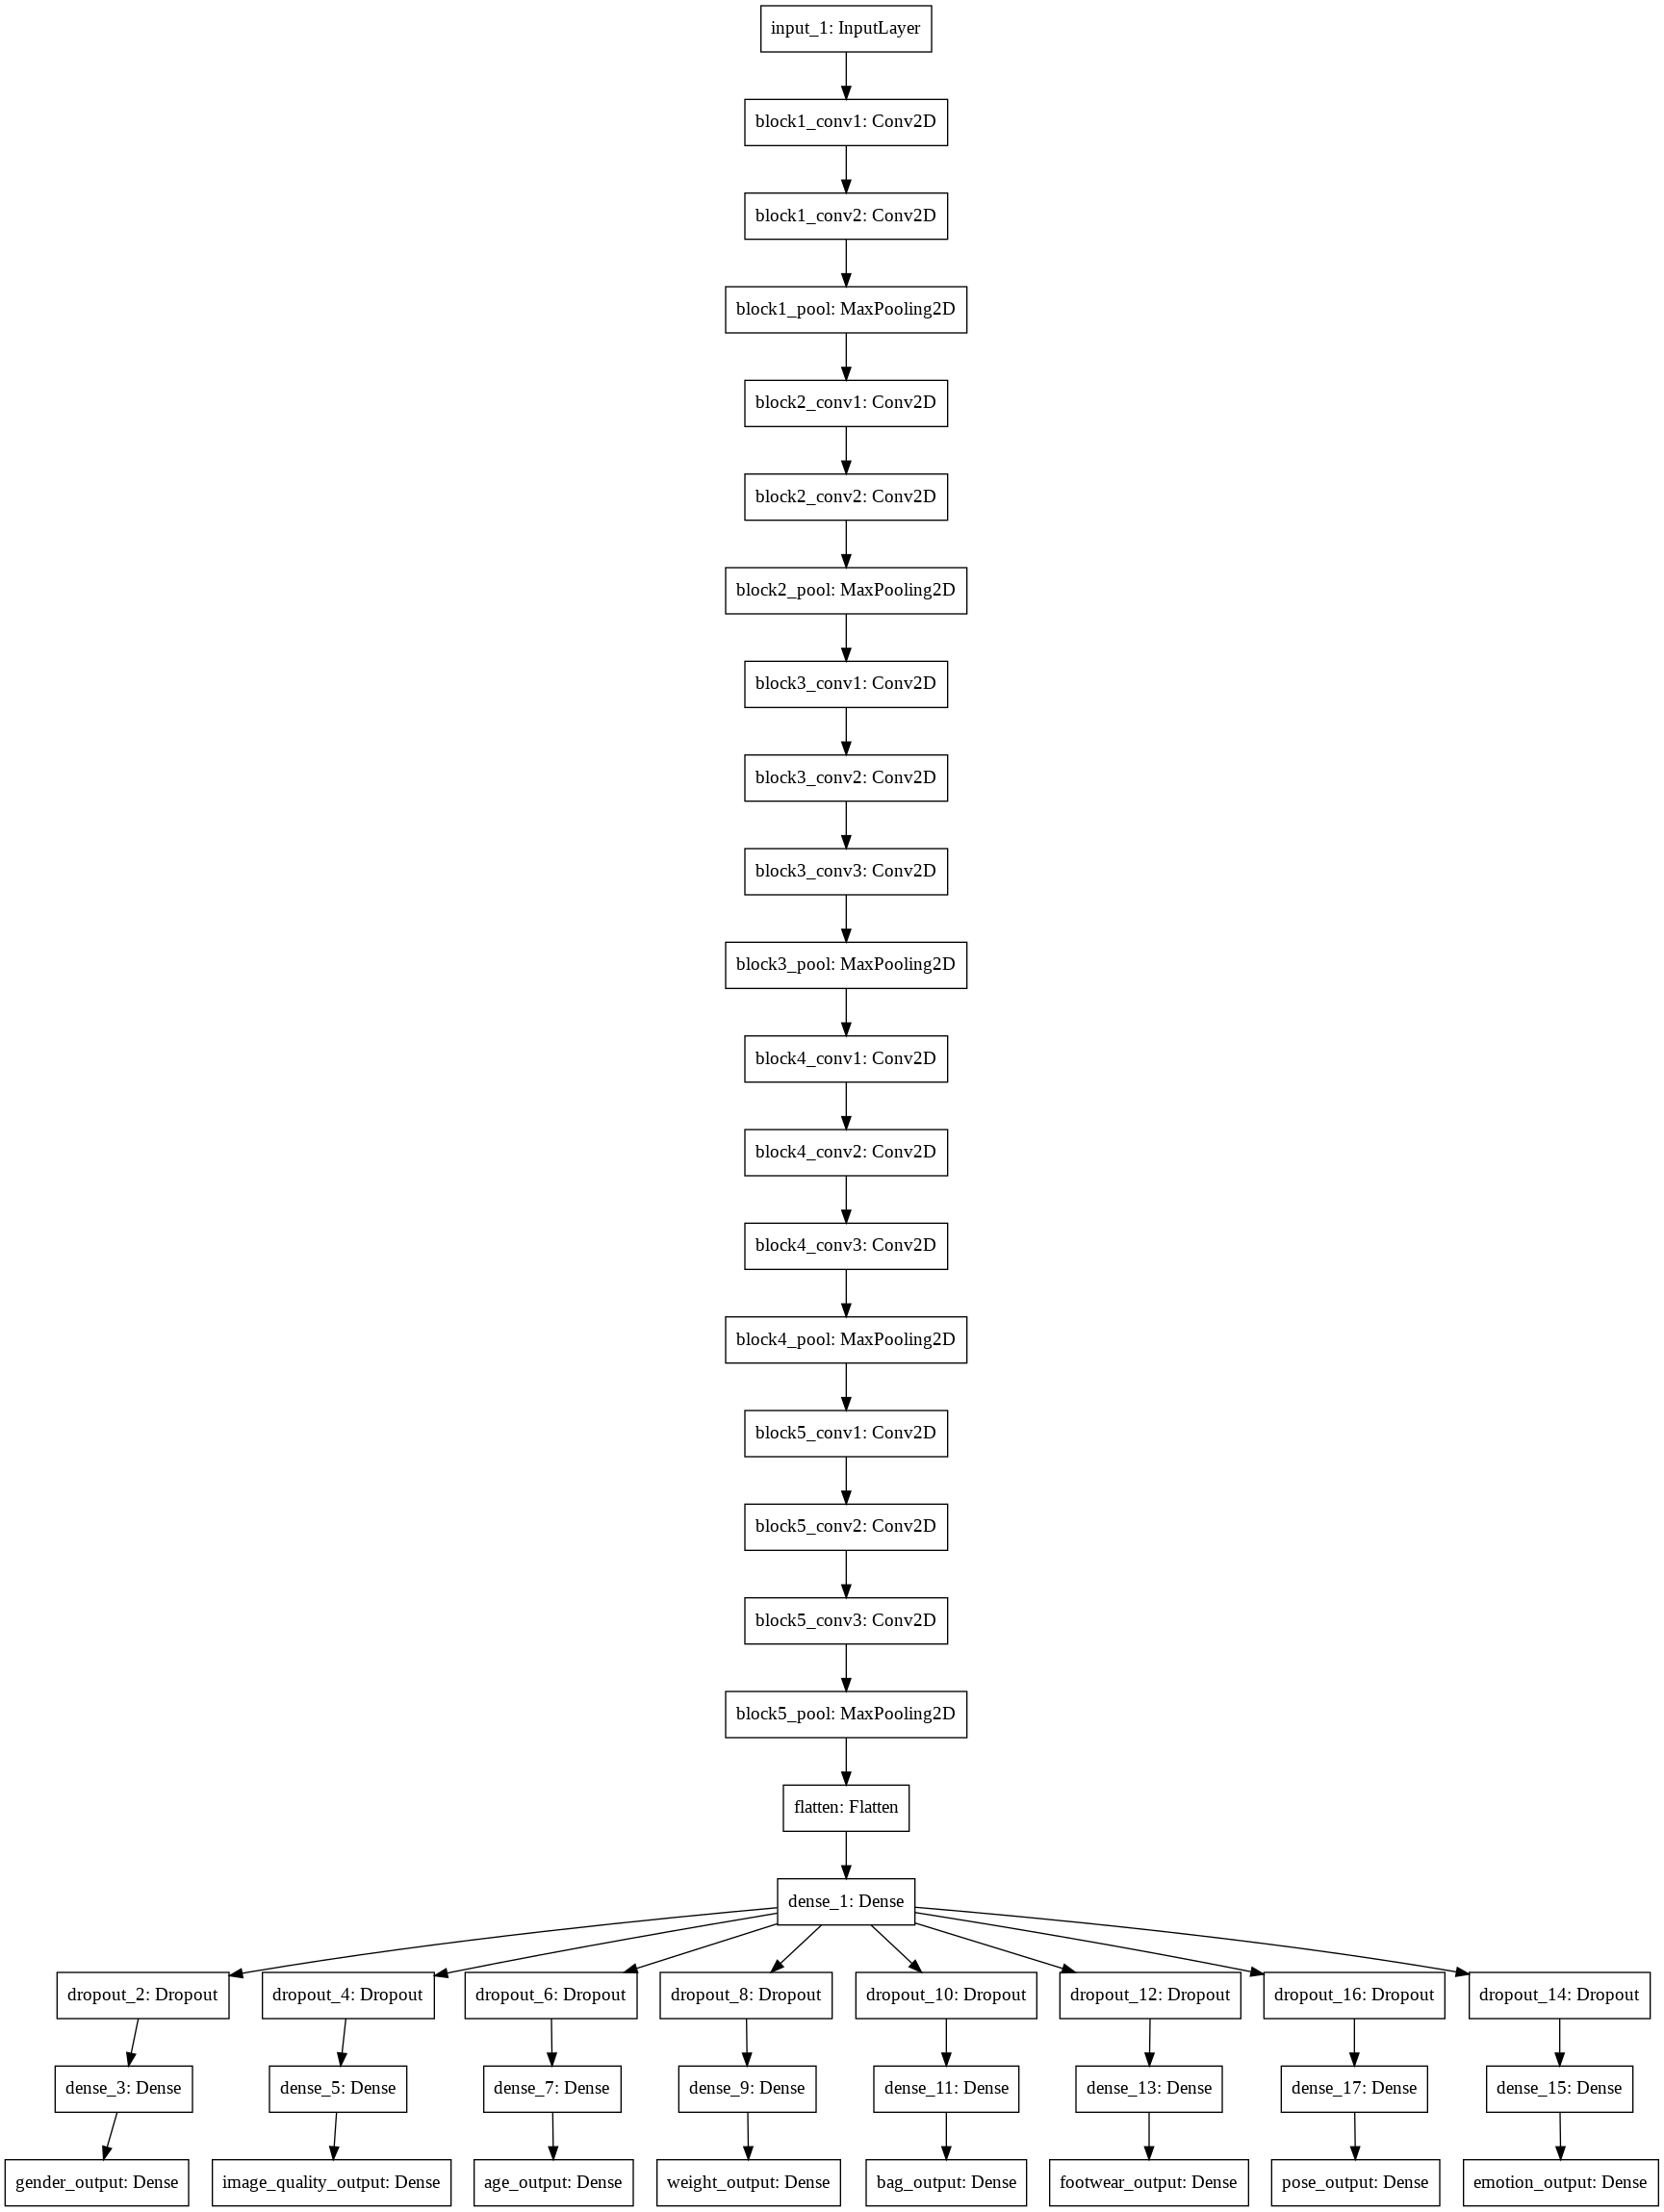

In [13]:
# Review model
from keras.utils import plot_model

model.summary()
plot_model(model, to_file='model.png')

In [0]:
def lr_schedule(epoch):
    """Learning Rate Schedule

    Learning rate is scheduled to be reduced after 10, 15, 30, 4 epochs.
    Called automatically every epoch as part of callbacks during training.

    # Arguments
        epoch (int): The number of epochs

    # Returns
        lr (float32): learning rate
    """
    lr = 1e-2
    if epoch > 40:
        lr *= 1e-10
    elif epoch > 30:
        lr *= 1e-8
    elif epoch > 20:
        lr *= 1e-6
    elif epoch > 10:
        lr *= 1e-4
    print('Learning rate: ', lr)
    return lr

In [21]:
# Prepare callbacks for model saving and for learning rate adjustment.
!git clone https://github.com/WittmannF/LRFinder.git
from LRFinder.keras_callback import LRFinder

filePath = 'weights.best.hdf5'
checkpoint = ModelCheckpoint(filepath=filePath,
                             monitor='val_loss',
                             verbose=1,
                             save_best_only=True)

#lr_scheduler = LearningRateScheduler(lr_schedule)
lr_finder = LRFinder(min_lr=1e-10, max_lr=1)

# callbacks = [checkpoint, lr_scheduler]
callbacks = [checkpoint, lr_finder]

fatal: destination path 'LRFinder' already exists and is not an empty directory.


In [0]:
# losses = {
# 	"gender_output": "binary_crossentropy",
# 	"image_quality_output": "categorical_crossentropy",
# 	"age_output": "categorical_crossentropy",
# 	"weight_output": "categorical_crossentropy",

# }
# loss_weights = {"gender_output": 1.0, "image_quality_output": 1.0, "age_output": 1.0}

opt = SGD(lr=lr_schedule(0), momentum=0.9)
model.compile(
    optimizer='sgd',
    loss="categorical_crossentropy", 
    # loss_weights=loss_weights, 
    metrics=["accuracy"]
)

lr = K.get_value(model.optimizer.lr)
print(lr)

In [0]:
# model.fit(X_train, y_train, validation_data=(X_valid, y_valid), batch_size=32, epochs=10)

In [0]:
H = model.fit_generator(
    generator=train_gen,
    validation_data=valid_gen,
    use_multiprocessing=True,
    workers=6, 
    epochs=5,
    verbose=1,
    callbacks=callbacks
)

In [28]:
  results = model.evaluate_generator(valid_gen, verbose=1)
  dict(zip(model.metrics_names, results))

31/31 [==============================] - 11s 349ms/step


{'age_output_acc': 0.3714717741935484,
 'age_output_loss': 1.483315613961989,
 'bag_output_acc': 0.5735887096774194,
 'bag_output_loss': 0.9477277013563341,
 'emotion_output_acc': 0.7167338709677419,
 'emotion_output_loss': 0.9578089079549236,
 'footwear_output_acc': 0.4415322580645161,
 'footwear_output_loss': 1.0561485367436563,
 'gender_output_acc': 0.5700604838709677,
 'gender_output_loss': 0.6842416967115095,
 'image_quality_output_acc': 0.5509072580645161,
 'image_quality_output_loss': 1.0028691464854824,
 'loss': 8.137925824811381,
 'pose_output_acc': 0.6189516129032258,
 'pose_output_loss': 0.9594378432919902,
 'weight_output_acc': 0.6305443548387096,
 'weight_output_loss': 1.0463763071644692}

In [25]:
print(H.history.keys())

dict_keys(['val_loss', 'val_gender_output_loss', 'val_image_quality_output_loss', 'val_age_output_loss', 'val_weight_output_loss', 'val_bag_output_loss', 'val_footwear_output_loss', 'val_pose_output_loss', 'val_emotion_output_loss', 'val_gender_output_acc', 'val_image_quality_output_acc', 'val_age_output_acc', 'val_weight_output_acc', 'val_bag_output_acc', 'val_footwear_output_acc', 'val_pose_output_acc', 'val_emotion_output_acc', 'loss', 'gender_output_loss', 'image_quality_output_loss', 'age_output_loss', 'weight_output_loss', 'bag_output_loss', 'footwear_output_loss', 'pose_output_loss', 'emotion_output_loss', 'gender_output_acc', 'image_quality_output_acc', 'age_output_acc', 'weight_output_acc', 'bag_output_acc', 'footwear_output_acc', 'pose_output_acc', 'emotion_output_acc', 'lr'])


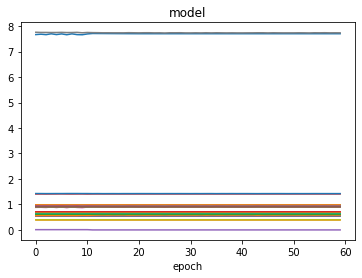

In [26]:
def plot(history):
  # summarize history for accuracy
  
  for k in history.history.keys():
    plt.plot(history.history[k])
  plt.title('model')
  plt.xlabel('epoch')
  # plt.legend(['val_loss', 
  #             'val_gender_output_loss', 
  #             'val_image_quality_output_loss', 
  #             'val_age_output_loss', 
  #             'val_weight_output_loss', 
  #             'val_bag_output_loss', 
  #             'val_footwear_output_loss', 
  #             'val_pose_output_loss', 
  #             'val_emotion_output_loss', 
  #             'val_gender_output_acc', 
  #             'val_image_quality_output_acc', 
  #             'val_age_output_acc', 
  #             'val_weight_output_acc', 
  #             'val_bag_output_acc', 
  #             'val_footwear_output_acc', 
  #             'val_pose_output_acc', 
  #             'val_emotion_output_acc', 
  #             'loss', 
  #             'gender_output_loss', 
  #             'image_quality_output_loss', 
  #             'age_output_loss', 
  #             'weight_output_loss', 
  #             'bag_output_loss', 
  #             'footwear_output_loss', 
  #             'pose_output_loss', 
  #             'emotion_output_loss', 
  #             'gender_output_acc', 
  #             'image_quality_output_acc', 
  #             'age_output_acc', 
  #             'weight_output_acc', 
  #             'bag_output_acc', 
  #             'footwear_output_acc', 'pose_output_acc', 'emotion_output_acc'], loc='upper left')
  plt.show()
  # summarize history for loss
  # plt.plot(history.history['loss'])
  # plt.plot(history.history['val_loss'])
  # plt.title('model loss')
  # plt.ylabel('loss')
  # plt.xlabel('epoch')
  # plt.legend(['train', 'test'], loc='upper left')
  # plt.show()

plot(H)

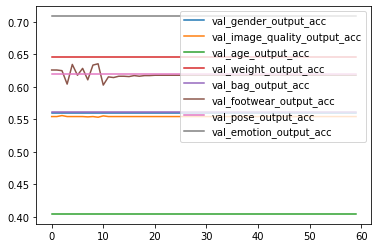

In [27]:
def plot_loss_and_acc(history):
  # plt.plot(history.history['loss'])
  # plt.plot(history.history['val_loss'])
  plt.plot(history.history['val_gender_output_acc'])
  plt.plot(history.history['val_image_quality_output_acc'])
  plt.plot(history.history['val_age_output_acc'])
  plt.plot(history.history['val_weight_output_acc'])
  plt.plot(history.history['val_bag_output_acc'])
  plt.plot(history.history['val_footwear_output_acc'])
  plt.plot(history.history['val_pose_output_acc'])
  plt.plot(history.history['val_emotion_output_acc'])
  
  plt.legend(['val_gender_output_acc', 
              'val_image_quality_output_acc', 
              'val_age_output_acc', 
              'val_weight_output_acc', 
              'val_bag_output_acc', 
              'val_footwear_output_acc', 
              'val_pose_output_acc', 
              'val_emotion_output_acc'], loc='upper right')
  plt.savefig('vgg16-untrained-50epochs.jpg')
  plt.show()

plot_loss_and_acc(H)

In [20]:
# Retrain model 

# load the model
model = load_model(filePath)

K.set_value(model.optimizer.lr, 1e-4)
lr = K.get_value(model.optimizer.lr)
print(lr)

H = model.fit_generator(
    generator=train_gen,
    validation_data=valid_gen,
    use_multiprocessing=True,
    workers=6, 
    epochs=20,
    verbose=1,
    callbacks=callbacks
)

KeyboardInterrupt: ignored

In [20]:
  results = model.evaluate_generator(valid_gen, verbose=1)
  dict(zip(model.metrics_names, results))

31/31 [==============================] - 12s 374ms/step


{'age_output_acc': 0.38961693548387094,
 'age_output_loss': 1.3911178188939248,
 'bag_output_acc': 0.5700604838709677,
 'bag_output_loss': 0.9084532453167823,
 'emotion_output_acc': 0.7081653225806451,
 'emotion_output_loss': 0.9158748695927281,
 'footwear_output_acc': 0.6164314516129032,
 'footwear_output_loss': 0.8508778079863517,
 'gender_output_acc': 0.6381048387096774,
 'gender_output_loss': 0.6265699421205828,
 'image_quality_output_acc': 0.561491935483871,
 'image_quality_output_loss': 0.9578217517945075,
 'loss': 7.5161551198651715,
 'pose_output_acc': 0.6063508064516129,
 'pose_output_loss': 0.9068958528580204,
 'weight_output_acc': 0.6370967741935484,
 'weight_output_loss': 0.9585437851567422}

In [21]:
# Retrain model 

# load the model
model = load_model(filePath)

K.set_value(model.optimizer.lr, 1e-6)
lr = K.get_value(model.optimizer.lr)
print(lr)

H = model.fit_generator(
    generator=train_gen,
    validation_data=valid_gen,
    use_multiprocessing=True,
    workers=6, 
    epochs=30,
    verbose=1,
    callbacks=callbacks
)

1e-06
Epoch 1/30
360/360 [==============================] - 91s 252ms/step - loss: 7.5075 - gender_output_loss: 0.6253 - image_quality_output_loss: 0.9602 - age_output_loss: 1.3933 - weight_output_loss: 0.9711 - bag_output_loss: 0.9004 - footwear_output_loss: 0.8635 - pose_output_loss: 0.8964 - emotion_output_loss: 0.8973 - gender_output_acc: 0.6381 - image_quality_output_acc: 0.5555 - age_output_acc: 0.4021 - weight_output_acc: 0.6352 - bag_output_acc: 0.5653 - footwear_output_acc: 0.6134 - pose_output_acc: 0.6201 - emotion_output_acc: 0.7119 - val_loss: 7.5104 - val_gender_output_loss: 0.6270 - val_image_quality_output_loss: 0.9575 - val_age_output_loss: 1.3904 - val_weight_output_loss: 0.9579 - val_bag_output_loss: 0.9084 - val_footwear_output_loss: 0.8467 - val_pose_output_loss: 0.9069 - val_emotion_output_loss: 0.9155 - val_gender_output_acc: 0.6391 - val_image_quality_output_acc: 0.5615 - val_age_output_acc: 0.3881 - val_weight_output_acc: 0.6371 - val_bag_output_acc: 0.5701 - va

In [22]:
  results = model.evaluate_generator(valid_gen, verbose=1)
  dict(zip(model.metrics_names, results))

31/31 [==============================] - 12s 376ms/step


{'age_output_acc': 0.3911290322580645,
 'age_output_loss': 1.3899336899480512,
 'bag_output_acc': 0.5700604838709677,
 'bag_output_loss': 0.9080106731384031,
 'emotion_output_acc': 0.7081653225806451,
 'emotion_output_loss': 0.9157512168730458,
 'footwear_output_acc': 0.6174395161290323,
 'footwear_output_loss': 0.8462165613328257,
 'gender_output_acc': 0.6376008064516129,
 'gender_output_loss': 0.6264831692941727,
 'image_quality_output_acc': 0.561491935483871,
 'image_quality_output_loss': 0.9577924936048446,
 'loss': 7.50841397623862,
 'pose_output_acc': 0.6063508064516129,
 'pose_output_loss': 0.9069510602181957,
 'weight_output_acc': 0.6370967741935484,
 'weight_output_loss': 0.957275019538018}

In [0]:
def printMaxAccuracy(history):
  for name in history.keys():
    if(name.startswith('val_') and name.endswith('_acc')):
      print(name + ': ' + str(round(np.max(history[name]), 4)))


In [0]:
printMaxAccuracy(H.history)

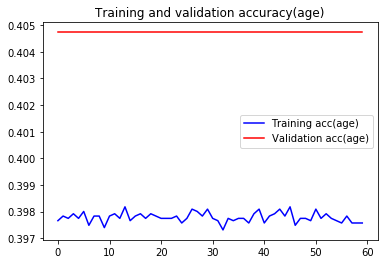

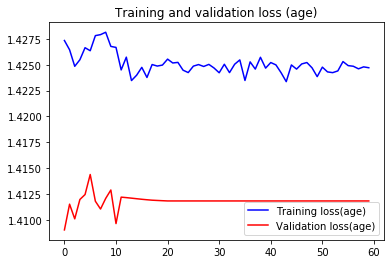

In [30]:
# Plot loss and accuracy curve for 'age'

acc = H.history['age_output_acc']
val_acc = H.history['val_age_output_acc']
loss = H.history['age_output_loss']
val_loss = H.history['val_age_output_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training acc(age)')
plt.plot(epochs, val_acc, 'r', label='Validation acc(age)')
plt.title('Training and validation accuracy(age)')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss(age)')
plt.plot(epochs, val_loss, 'r', label='Validation loss(age)')
plt.title('Training and validation loss (age)')
plt.legend()
 
plt.show()